# Data filtering

In [1]:
!python -V

Python 3.8.5


In [74]:
import pandas as pd
data = pd.read_csv("Banknifty2014_2018.csv", dtype={'Change in OI': int}, na_values=['-'])
data.rename(columns={'Symbol  ': 'Symbol', 'Date  ': 'Date','Expiry  ':'Expiry','Option type  ':'Option type','Strike Price  ':'Strike Price','Open  ':'Open','High  ':'High','Low  ':'Low','Close  ':'Close','LTP  ':'LTP','Settle Price  ':'Settle Price', 'No. of contracts  ':'No. of contracts','Turnover in Lakhs':'Turnover in Lakhs','Open Int  ':'Open Int','Change in OI  ':'Change in OI','Underlying Value  ':'Underlying Value'},inplace=True)
data = data.reset_index(drop=True)
data

,Symbol,Date,Expiry,Option type,Strike Price,Open,High,Low,Close,LTP,Settle Price,No. of contracts,Turnover * in ₹ Lakhs,Premium Turnover ** in ₹ Lakhs,Open Int,Change in OI,Underlying Value,Turnover in Lakhs,Premium Turnover in Lakhs
0,BANKNIFTY,01-Jan-2014,30-Jan-2014,CE,10000.0,1471.1,1481.0,1471.1,1481.00,1481.00,1481.00,3.0,8.61,110627.5,9675.0,NaN,11385.6,NaN,NaN
1,BANKNIFTY,01-Jan-2014,30-Jan-2014,CE,10100.0,NaN,NaN,NaN,928.00,928.00,1384.00,NaN,NaN,NaN,25.0,NaN,11385.6,NaN,NaN
2,BANKNIFTY,01-Jan-2014,30-Jan-2014,CE,10200.0,NaN,NaN,NaN,1331.75,1331.75,1292.85,NaN,NaN,NaN,50.0,NaN,11385.6,NaN,NaN
3,BANKNIFTY,01-Jan-2014,30-Jan-2014,CE,10300.0,NaN,NaN,NaN,1180.00,1180.00,1203.55,NaN,NaN,NaN,325.0,NaN,11385.6,NaN,NaN
4,BANKNIFTY,01-Jan-2014,30-Jan-2014,CE,10400.0,1095.0,1095.0,1095.0,1095.00,1095.00,1095.00,4.0,11.49,109500.0,650.0,NaN,11385.6,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359876,BANKNIFTY,31-Dec-18,28-Mar-19,CE,25700.0,NaN,NaN,NaN,1994.65,NaN,2163.55,NaN,NaN,NaN,NaN,NaN,27160.2,NaN,NaN
359877,BANKNIFTY,31-Dec-18,28-Mar-19,CE,25600.0,NaN,NaN,NaN,2067.25,NaN,2241.70,NaN,NaN,NaN,NaN,NaN,27160.2,NaN,NaN
359878,BANKNIFTY,31-Dec-18,28-Mar-19,CE,25500.0,NaN,NaN,NaN,2142.10,NaN,2321.15,NaN,NaN,NaN,NaN,NaN,27160.2,NaN,NaN
359879,BANKNIFTY,31-Dec-18,28-Mar-19,CE,25400.0,NaN,NaN,NaN,2218.25,NaN,2401.75,NaN,NaN,NaN,NaN,NaN,27160.2,NaN,NaN


In [75]:
#Adding the close column of the previous day of the beginning of the contract
from datetime import datetime, timedelta
data.loc[:, 'Date'] = pd.to_datetime(data.loc[:, 'Date'])
selected_columns = ['Date', 'Expiry','Strike Price', 'Close','No. of contracts']
extracted= data[selected_columns]
K_C=extracted.groupby('Date')



In [ ]:
#add a column that records the close price of the previous day 
c=[]
added=[]
for s in range(len(data)):
    start_date=data.loc[s,'Date']
    k=data.loc[s,'Strike Price']
    start_date = start_date - timedelta(days=1)
    if start_date in list(K_C.groups.keys()):    
        X=K_C.get_group(start_date)      #get the part of the groupped data for this date
        i = X['Strike Price'][(X['Strike Price'] == k) & (X['Expiry'] == data.loc[s, 'Expiry'])].index 
        if len(i)>0:         
            close=X.loc[i, 'Close']      #get the close price corresponding to that option contract
            c.append((close.iloc[0])/k)  #add the value to the list c
            added.append(s)
        else:
            c.append(0)
    else:
        c.append(0)
previous_day_close = pd.Series(c, name='previous day close')
data['A day before_Close']=previous_day_close 

In [76]:
import math
s=0
t=[] #will contain the list of the rows that we will drop
for s in added:   # check if the option's close price of the previous day is obtained from a non-traded option and store the row index if so
    start_date=data.loc[s,'Date']
    k=data.loc[s,'Strike Price']
    start_date = start_date - timedelta(days=1)
    if start_date in list(K_C.groups.keys()):    
        X=K_C.get_group(start_date)      #get the part of the groupped data for this date
        i = X['Strike Price'][(X['Strike Price'] == k) & (X['Expiry'] == data.loc[s, 'Expiry'])].index 
        if ((len(i)>0)and(pd.isna(X.loc[i, 'No. of contracts']).any())):    #If the previous day's option is not traded then,     
            t.append(s)                                                 #get the indexes of the rows to drop


In [77]:
data = data.drop(t)   #drop the obtained rows using t array
data

,Symbol,Date,Expiry,Option type,Strike Price,Open,High,Low,Close,LTP,Settle Price,No. of contracts,Turnover * in ₹ Lakhs,Premium Turnover ** in ₹ Lakhs,Open Int,Change in OI,Underlying Value,Turnover in Lakhs,Premium Turnover in Lakhs,A day before_Close
0,BANKNIFTY,2014-01-01,30-Jan-2014,CE,10000.0,1471.1,1481.0,1471.1,1481.00,1481.00,1481.00,3.0,8.61,110627.5,9675.0,NaN,11385.6,NaN,NaN,0.0
1,BANKNIFTY,2014-01-01,30-Jan-2014,CE,10100.0,NaN,NaN,NaN,928.00,928.00,1384.00,NaN,NaN,NaN,25.0,NaN,11385.6,NaN,NaN,0.0
2,BANKNIFTY,2014-01-01,30-Jan-2014,CE,10200.0,NaN,NaN,NaN,1331.75,1331.75,1292.85,NaN,NaN,NaN,50.0,NaN,11385.6,NaN,NaN,0.0
3,BANKNIFTY,2014-01-01,30-Jan-2014,CE,10300.0,NaN,NaN,NaN,1180.00,1180.00,1203.55,NaN,NaN,NaN,325.0,NaN,11385.6,NaN,NaN,0.0
4,BANKNIFTY,2014-01-01,30-Jan-2014,CE,10400.0,1095.0,1095.0,1095.0,1095.00,1095.00,1095.00,4.0,11.49,109500.0,650.0,NaN,11385.6,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359876,BANKNIFTY,2018-12-31,28-Mar-19,CE,25700.0,NaN,NaN,NaN,1994.65,NaN,2163.55,NaN,NaN,NaN,NaN,NaN,27160.2,NaN,NaN,0.0
359877,BANKNIFTY,2018-12-31,28-Mar-19,CE,25600.0,NaN,NaN,NaN,2067.25,NaN,2241.70,NaN,NaN,NaN,NaN,NaN,27160.2,NaN,NaN,0.0
359878,BANKNIFTY,2018-12-31,28-Mar-19,CE,25500.0,NaN,NaN,NaN,2142.10,NaN,2321.15,NaN,NaN,NaN,NaN,NaN,27160.2,NaN,NaN,0.0
359879,BANKNIFTY,2018-12-31,28-Mar-19,CE,25400.0,NaN,NaN,NaN,2218.25,NaN,2401.75,NaN,NaN,NaN,NaN,NaN,27160.2,NaN,NaN,0.0


In [78]:
#Remove the rows that do are not traded on the previous day of the beginning of the contract

data=data[data['A day before_Close'] != 0]
data = data.reset_index(drop=True)
data

,Symbol,Date,Expiry,Option type,Strike Price,Open,High,Low,Close,LTP,Settle Price,No. of contracts,Turnover * in ₹ Lakhs,Premium Turnover ** in ₹ Lakhs,Open Int,Change in OI,Underlying Value,Turnover in Lakhs,Premium Turnover in Lakhs,A day before_Close
0,BANKNIFTY,2014-01-02,30-Jan-2014,CE,10000.0,1644.00,1644.00,1250.00,1250.00,1250.00,1250.00,22.0,63.46,845838.75,9825.0,150.0,11183.2,NaN,NaN,0.148100
1,BANKNIFTY,2014-01-02,30-Jan-2014,CE,10400.0,1147.20,1147.20,1147.20,1147.20,1147.20,1147.20,1.0,2.89,28680.00,650.0,NaN,11183.2,NaN,NaN,0.105288
2,BANKNIFTY,2014-01-02,30-Jan-2014,CE,10500.0,1180.00,1180.00,956.65,956.65,956.65,956.65,16.0,46.28,427736.25,3450.0,175.0,11183.2,NaN,NaN,0.096129
3,BANKNIFTY,2014-01-02,30-Jan-2014,CE,11000.0,590.00,751.45,430.05,456.20,440.00,456.20,422.0,1218.46,5796193.75,22725.0,575.0,11183.2,NaN,NaN,0.056300
4,BANKNIFTY,2014-01-02,30-Jan-2014,CE,11100.0,564.75,627.75,400.00,424.60,410.00,424.60,45.0,130.17,529275.00,1450.0,550.0,11183.2,NaN,NaN,0.047608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54340,BANKNIFTY,2018-12-28,28-Feb-19,CE,28000.0,326.65,368.75,326.65,355.90,357.05,355.90,141.0,NaN,NaN,3100.0,1080.0,NaN,799.63,10.03,0.010111
54341,BANKNIFTY,2018-12-28,28-Feb-19,CE,27500.0,500.00,580.00,500.00,562.10,562.10,562.10,18.0,NaN,NaN,240.0,120.0,NaN,101.00,2.00,0.017335
54342,BANKNIFTY,2018-12-28,28-Feb-19,CE,27000.0,846.60,878.05,830.00,866.10,878.05,866.10,59.0,NaN,NaN,1280.0,1120.0,NaN,328.63,10.03,0.029622
54343,BANKNIFTY,2018-12-28,28-Feb-19,CE,26500.0,1170.00,1236.50,1169.90,1196.95,1196.95,1196.95,7.0,NaN,NaN,160.0,100.0,NaN,38.76,1.66,0.039623


In [79]:
#We remove the contracts that are not traded
data = data.dropna(subset=['No. of contracts'])
data = data.reset_index(drop=True)
data

,Symbol,Date,Expiry,Option type,Strike Price,Open,High,Low,Close,LTP,Settle Price,No. of contracts,Turnover * in ₹ Lakhs,Premium Turnover ** in ₹ Lakhs,Open Int,Change in OI,Underlying Value,Turnover in Lakhs,Premium Turnover in Lakhs,A day before_Close
0,BANKNIFTY,2014-01-02,30-Jan-2014,CE,10000.0,1644.00,1644.00,1250.00,1250.00,1250.00,1250.00,22.0,63.46,845838.75,9825.0,150.0,11183.2,NaN,NaN,0.148100
1,BANKNIFTY,2014-01-02,30-Jan-2014,CE,10400.0,1147.20,1147.20,1147.20,1147.20,1147.20,1147.20,1.0,2.89,28680.00,650.0,NaN,11183.2,NaN,NaN,0.105288
2,BANKNIFTY,2014-01-02,30-Jan-2014,CE,10500.0,1180.00,1180.00,956.65,956.65,956.65,956.65,16.0,46.28,427736.25,3450.0,175.0,11183.2,NaN,NaN,0.096129
3,BANKNIFTY,2014-01-02,30-Jan-2014,CE,11000.0,590.00,751.45,430.05,456.20,440.00,456.20,422.0,1218.46,5796193.75,22725.0,575.0,11183.2,NaN,NaN,0.056300
4,BANKNIFTY,2014-01-02,30-Jan-2014,CE,11100.0,564.75,627.75,400.00,424.60,410.00,424.60,45.0,130.17,529275.00,1450.0,550.0,11183.2,NaN,NaN,0.047608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50655,BANKNIFTY,2018-12-28,31-Jan-19,CE,23000.0,4240.00,4291.05,4210.00,4218.00,4218.00,4218.00,75.0,NaN,NaN,16060.0,-20.0,NaN,408.71,63.71,0.172880
50656,BANKNIFTY,2018-12-28,28-Feb-19,CE,28000.0,326.65,368.75,326.65,355.90,357.05,355.90,141.0,NaN,NaN,3100.0,1080.0,NaN,799.63,10.03,0.010111
50657,BANKNIFTY,2018-12-28,28-Feb-19,CE,27500.0,500.00,580.00,500.00,562.10,562.10,562.10,18.0,NaN,NaN,240.0,120.0,NaN,101.00,2.00,0.017335
50658,BANKNIFTY,2018-12-28,28-Feb-19,CE,27000.0,846.60,878.05,830.00,866.10,878.05,866.10,59.0,NaN,NaN,1280.0,1120.0,NaN,328.63,10.03,0.029622


In [80]:
data = data.dropna(subset=['Underlying Value'])
data = data.reset_index(drop=True)
underlying = pd.read_csv("Nifty Bank Historical Data 2014_2018.csv", dtype={'Change in OI': int}, na_values=['-'])
underlying = underlying.iloc[::-1]
selected_columns = ['Date','Open','High','Low','Close']
underlying = underlying.reset_index(drop=True)
underlying[selected_columns]

,Date,Open,High,Low,Close
0,1/1/2014,"11,418.90","11,432.55","11,361.00","11,385.60"
1,1/2/2014,"11,383.80","11,578.90","11,150.20","11,183.20"
2,1/3/2014,"11,098.25","11,208.00","11,052.60","11,181.65"
3,1/6/2014,"11,174.35","11,174.35","10,996.95","11,049.05"
4,1/7/2014,"11,097.80","11,154.10","10,892.15","11,036.75"
...,...,...,...,...,...
1228,12/24/2018,"26,877.05","26,934.85","26,676.95","26,714.75"
1229,12/26/2018,"26,634.00","27,029.15","26,408.15","26,986.80"
1230,12/27/2018,"27,200.65","27,239.95","26,845.10","26,878.55"
1231,12/28/2018,"27,048.40","27,213.45","27,039.60","27,125.25"


In [81]:
#Adding a column containing the underlying close value of the past 20 trading days:
data.loc[:, 'Date'] = pd.to_datetime(data.loc[:, 'Date'])
data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
underlying.loc[:, 'Date'] = pd.to_datetime(underlying.loc[:, 'Date'])
# Convert 'Date' column to the desired format
underlying['Date'] = underlying['Date'].dt.strftime('%Y-%m-%d')
selected_columns = ['Date','Open','High','Low','Close']
extracted= underlying[selected_columns]
D_U=extracted.groupby('Date')
w=list(D_U.groups.keys())   #list containing all the dates, ordered.
data['last20_Close'] = None
L=[]
p=''
i=0
for start_date in data['Date']:
    if(start_date==p and(L!='')):
        data.at[i, 'last20_Close'] = L

    else:
        L=[]
        p=start_date
        j=1
        while j<=20:
            j_thprevious=w[w.index(start_date) - j]
            L.append(D_U.get_group(j_thprevious)['Close'].iloc[0])
            j+=1
        data.at[i, 'last20_Close'] = L
    i+=1

In [82]:
#Adding a column containing the underlying Open value of the past 20 trading days:
selected_columns = ['Date','Open','High','Low','Open']
extracted= underlying[selected_columns]
D_U=extracted.groupby('Date')
w=list(D_U.groups.keys())   #list containing all the dates, ordered.
data['last20_Open'] = None
L=[]
p=''
i=0
for start_date in data['Date']:
    if(start_date==p and(L!='')):
        data.at[i, 'last20_Open'] = L

    else:
        L=[]
        p=start_date
        j=1
        while j<=20:
            j_thprevious=w[w.index(start_date) - j]
            L.append(D_U.get_group(j_thprevious)['Open'].iloc[0][0])
            j+=1
        data.at[i, 'last20_Open'] = L
    i+=1

In [83]:
#Adding a column containing the underlying High value of the past 20 trading days:
selected_columns = ['Date','Open','High','Low']
extracted= underlying[selected_columns]
D_U=extracted.groupby('Date')
w=list(D_U.groups.keys())   #list containing all the dates, ordered.
data['last20_High'] = None
L=[]
p=''
i=0
for start_date in data['Date']:
    if(start_date==p and(L!='')):
        data.at[i, 'last20_High'] = L

    else:
        L=[]
        p=start_date
        j=1
        while j<=20:
            j_thprevious=w[w.index(start_date) - j]
            L.append(D_U.get_group(j_thprevious)['High'].iloc[0])
            j+=1
        data.at[i, 'last20_High'] = L
    i+=1

In [84]:
#Adding a column containing the underlying Low value of the past 20 trading days:
selected_columns = ['Date','Low']
extracted= underlying[selected_columns]
D_U=extracted.groupby('Date')
w=list(D_U.groups.keys())   #list containing all the dates, ordered.
data['last20_Low'] = None
L=[]
p=''
i=0
for start_date in data['Date']:
    if(start_date==p and(L!='')):
        data.at[i, 'last20_Low'] = L

    else:
        L=[]
        p=start_date
        j=1
        while j<=20:
            j_thprevious=w[w.index(start_date) - j]
            L.append(D_U.get_group(j_thprevious)['Low'].iloc[0])
            j+=1
        data.at[i, 'last20_Low'] = L
    i+=1

In [85]:
interest_rate = pd.read_csv("Government bond yield rate.csv")
#Adding a column containing the underlying close value of the past 20 trading days:
interest_rate.loc[:, 'Date'] = pd.to_datetime(interest_rate.loc[:, 'Date'])
interest_rate['Date'] = interest_rate['Date'].dt.strftime('%Y-%m-%d')
data.loc[:, 'Date'] = pd.to_datetime(data.loc[:, 'Date'])
# Convert 'Date' column to the desired format
data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
D_U=interest_rate.groupby('Date')
w=list(D_U.groups.keys())   #list containing all the dates, ordered.
data['government bond yield rate'] = None
i=0
for start_date in data['Date']:
    if(start_date in w):
        data.at[i, 'government bond yield rate'] = D_U.get_group(start_date)['Price'].iloc[0]
    i+=1
    
data['government bond yield rate'] = data['government bond yield rate'].astype(float)

data

,Symbol,Date,Expiry,Option type,Strike Price,Open,High,Low,Close,LTP,...,Change in OI,Underlying Value,Turnover in Lakhs,Premium Turnover in Lakhs,A day before_Close,last20_Close,last20_Open,last20_High,last20_Low,government bond yield rate
0,BANKNIFTY,2014-01-02,30-Jan-2014,CE,10000.0,1644.00,1644.00,1250.00,1250.00,1250.00,...,150.0,11183.2,NaN,NaN,0.148100,"[11,385.60, 27,160.20, 27,125.25, 26,878.55, 2...","[11,418.90, 27,267.80, 27,048.40, 27,200.65, 2...","[11,432.55, 27,286.50, 27,213.45, 27,239.95, 2...","[11,361.00, 27,105.00, 27,039.60, 26,845.10, 2...",NaN
1,BANKNIFTY,2014-01-02,30-Jan-2014,CE,10400.0,1147.20,1147.20,1147.20,1147.20,1147.20,...,NaN,11183.2,NaN,NaN,0.105288,"[11,385.60, 27,160.20, 27,125.25, 26,878.55, 2...","[11,418.90, 27,267.80, 27,048.40, 27,200.65, 2...","[11,432.55, 27,286.50, 27,213.45, 27,239.95, 2...","[11,361.00, 27,105.00, 27,039.60, 26,845.10, 2...",NaN
2,BANKNIFTY,2014-01-02,30-Jan-2014,CE,10500.0,1180.00,1180.00,956.65,956.65,956.65,...,175.0,11183.2,NaN,NaN,0.096129,"[11,385.60, 27,160.20, 27,125.25, 26,878.55, 2...","[11,418.90, 27,267.80, 27,048.40, 27,200.65, 2...","[11,432.55, 27,286.50, 27,213.45, 27,239.95, 2...","[11,361.00, 27,105.00, 27,039.60, 26,845.10, 2...",NaN
3,BANKNIFTY,2014-01-02,30-Jan-2014,CE,11000.0,590.00,751.45,430.05,456.20,440.00,...,575.0,11183.2,NaN,NaN,0.056300,"[11,385.60, 27,160.20, 27,125.25, 26,878.55, 2...","[11,418.90, 27,267.80, 27,048.40, 27,200.65, 2...","[11,432.55, 27,286.50, 27,213.45, 27,239.95, 2...","[11,361.00, 27,105.00, 27,039.60, 26,845.10, 2...",NaN
4,BANKNIFTY,2014-01-02,30-Jan-2014,CE,11100.0,564.75,627.75,400.00,424.60,410.00,...,550.0,11183.2,NaN,NaN,0.047608,"[11,385.60, 27,160.20, 27,125.25, 26,878.55, 2...","[11,418.90, 27,267.80, 27,048.40, 27,200.65, 2...","[11,432.55, 27,286.50, 27,213.45, 27,239.95, 2...","[11,361.00, 27,105.00, 27,039.60, 26,845.10, 2...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44904,BANKNIFTY,2018-12-19,31-Jan-19,CE,26000.0,1537.25,1598.00,1532.00,1546.75,1541.00,...,1600.0,27298.4,711.38,40.58,0.056075,"[27,174.70, 27,015.80, 26,826.00, 26,816.35, 2...","[26,917.30, 26,915.45, 26,810.85, 26,844.15, 2...","[27,210.05, 27,051.40, 26,909.00, 26,951.45, 2...","[26,840.80, 26,908.60, 26,732.70, 26,723.65, 2...",6.65
44905,BANKNIFTY,2018-12-19,31-Jan-19,CE,25500.0,2010.00,2025.00,1947.00,1999.95,1990.00,...,180.0,27298.4,71.48,5.18,0.074086,"[27,174.70, 27,015.80, 26,826.00, 26,816.35, 2...","[26,917.30, 26,915.45, 26,810.85, 26,844.15, 2...","[27,210.05, 27,051.40, 26,909.00, 26,951.45, 2...","[26,840.80, 26,908.60, 26,732.70, 26,723.65, 2...",6.65
44906,BANKNIFTY,2018-12-19,31-Jan-19,CE,25000.0,2450.00,2500.00,2440.00,2475.65,2475.65,...,260.0,27298.4,71.44,6.44,0.093868,"[27,174.70, 27,015.80, 26,826.00, 26,816.35, 2...","[26,917.30, 26,915.45, 26,810.85, 26,844.15, 2...","[27,210.05, 27,051.40, 26,909.00, 26,951.45, 2...","[26,840.80, 26,908.60, 26,732.70, 26,723.65, 2...",6.65
44907,BANKNIFTY,2018-12-19,31-Jan-19,CE,28500.0,125.00,140.00,118.30,126.15,123.00,...,11820.0,27298.4,7306.57,33.37,0.003884,"[27,174.70, 27,015.80, 26,826.00, 26,816.35, 2...","[26,917.30, 26,915.45, 26,810.85, 26,844.15, 2...","[27,210.05, 27,051.40, 26,909.00, 26,951.45, 2...","[26,840.80, 26,908.60, 26,732.70, 26,723.65, 2...",6.65


In [86]:
#Get only contracts which are near ATM with the predecided value 0.4 for the following difference
bool_ATM= abs(1-data['Underlying Value']/data['Strike Price'])<=0.4
data = data[bool_ATM.values]
data

,Symbol,Date,Expiry,Option type,Strike Price,Open,High,Low,Close,LTP,...,Change in OI,Underlying Value,Turnover in Lakhs,Premium Turnover in Lakhs,A day before_Close,last20_Close,last20_Open,last20_High,last20_Low,government bond yield rate
0,BANKNIFTY,2014-01-02,30-Jan-2014,CE,10000.0,1644.00,1644.00,1250.00,1250.00,1250.00,...,150.0,11183.2,NaN,NaN,0.148100,"[11,385.60, 27,160.20, 27,125.25, 26,878.55, 2...","[11,418.90, 27,267.80, 27,048.40, 27,200.65, 2...","[11,432.55, 27,286.50, 27,213.45, 27,239.95, 2...","[11,361.00, 27,105.00, 27,039.60, 26,845.10, 2...",NaN
1,BANKNIFTY,2014-01-02,30-Jan-2014,CE,10400.0,1147.20,1147.20,1147.20,1147.20,1147.20,...,NaN,11183.2,NaN,NaN,0.105288,"[11,385.60, 27,160.20, 27,125.25, 26,878.55, 2...","[11,418.90, 27,267.80, 27,048.40, 27,200.65, 2...","[11,432.55, 27,286.50, 27,213.45, 27,239.95, 2...","[11,361.00, 27,105.00, 27,039.60, 26,845.10, 2...",NaN
2,BANKNIFTY,2014-01-02,30-Jan-2014,CE,10500.0,1180.00,1180.00,956.65,956.65,956.65,...,175.0,11183.2,NaN,NaN,0.096129,"[11,385.60, 27,160.20, 27,125.25, 26,878.55, 2...","[11,418.90, 27,267.80, 27,048.40, 27,200.65, 2...","[11,432.55, 27,286.50, 27,213.45, 27,239.95, 2...","[11,361.00, 27,105.00, 27,039.60, 26,845.10, 2...",NaN
3,BANKNIFTY,2014-01-02,30-Jan-2014,CE,11000.0,590.00,751.45,430.05,456.20,440.00,...,575.0,11183.2,NaN,NaN,0.056300,"[11,385.60, 27,160.20, 27,125.25, 26,878.55, 2...","[11,418.90, 27,267.80, 27,048.40, 27,200.65, 2...","[11,432.55, 27,286.50, 27,213.45, 27,239.95, 2...","[11,361.00, 27,105.00, 27,039.60, 26,845.10, 2...",NaN
4,BANKNIFTY,2014-01-02,30-Jan-2014,CE,11100.0,564.75,627.75,400.00,424.60,410.00,...,550.0,11183.2,NaN,NaN,0.047608,"[11,385.60, 27,160.20, 27,125.25, 26,878.55, 2...","[11,418.90, 27,267.80, 27,048.40, 27,200.65, 2...","[11,432.55, 27,286.50, 27,213.45, 27,239.95, 2...","[11,361.00, 27,105.00, 27,039.60, 26,845.10, 2...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44904,BANKNIFTY,2018-12-19,31-Jan-19,CE,26000.0,1537.25,1598.00,1532.00,1546.75,1541.00,...,1600.0,27298.4,711.38,40.58,0.056075,"[27,174.70, 27,015.80, 26,826.00, 26,816.35, 2...","[26,917.30, 26,915.45, 26,810.85, 26,844.15, 2...","[27,210.05, 27,051.40, 26,909.00, 26,951.45, 2...","[26,840.80, 26,908.60, 26,732.70, 26,723.65, 2...",6.65
44905,BANKNIFTY,2018-12-19,31-Jan-19,CE,25500.0,2010.00,2025.00,1947.00,1999.95,1990.00,...,180.0,27298.4,71.48,5.18,0.074086,"[27,174.70, 27,015.80, 26,826.00, 26,816.35, 2...","[26,917.30, 26,915.45, 26,810.85, 26,844.15, 2...","[27,210.05, 27,051.40, 26,909.00, 26,951.45, 2...","[26,840.80, 26,908.60, 26,732.70, 26,723.65, 2...",6.65
44906,BANKNIFTY,2018-12-19,31-Jan-19,CE,25000.0,2450.00,2500.00,2440.00,2475.65,2475.65,...,260.0,27298.4,71.44,6.44,0.093868,"[27,174.70, 27,015.80, 26,826.00, 26,816.35, 2...","[26,917.30, 26,915.45, 26,810.85, 26,844.15, 2...","[27,210.05, 27,051.40, 26,909.00, 26,951.45, 2...","[26,840.80, 26,908.60, 26,732.70, 26,723.65, 2...",6.65
44907,BANKNIFTY,2018-12-19,31-Jan-19,CE,28500.0,125.00,140.00,118.30,126.15,123.00,...,11820.0,27298.4,7306.57,33.37,0.003884,"[27,174.70, 27,015.80, 26,826.00, 26,816.35, 2...","[26,917.30, 26,915.45, 26,810.85, 26,844.15, 2...","[27,210.05, 27,051.40, 26,909.00, 26,951.45, 2...","[26,840.80, 26,908.60, 26,732.70, 26,723.65, 2...",6.65


In [87]:
#We remove contracts where time to maturity is longer than 45 days or smaller than 3 days
data.loc[:, 'Date'] = pd.to_datetime(data.loc[:, 'Date'])
data.loc[:, 'Expiry'] = pd.to_datetime(data.loc[:, 'Expiry'] )

date_difference = data['Expiry'] - data['Date']

# Create a pandas Series with True where the difference is between 3 and 45 days, and False elsewhere
result_series = (date_difference >= pd.Timedelta(days=3)) & (date_difference <= pd.Timedelta(days=45))
data = data[result_series.values]
data

C:\Users\thous\anaconda3\envs\newlast\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,Symbol,Date,Expiry,Option type,Strike Price,Open,High,Low,Close,LTP,...,Change in OI,Underlying Value,Turnover in Lakhs,Premium Turnover in Lakhs,A day before_Close,last20_Close,last20_Open,last20_High,last20_Low,government bond yield rate
0,BANKNIFTY,2014-01-02,2014-01-30,CE,10000.0,1644.00,1644.00,1250.00,1250.00,1250.00,...,150.0,11183.2,NaN,NaN,0.148100,"[11,385.60, 27,160.20, 27,125.25, 26,878.55, 2...","[11,418.90, 27,267.80, 27,048.40, 27,200.65, 2...","[11,432.55, 27,286.50, 27,213.45, 27,239.95, 2...","[11,361.00, 27,105.00, 27,039.60, 26,845.10, 2...",NaN
1,BANKNIFTY,2014-01-02,2014-01-30,CE,10400.0,1147.20,1147.20,1147.20,1147.20,1147.20,...,NaN,11183.2,NaN,NaN,0.105288,"[11,385.60, 27,160.20, 27,125.25, 26,878.55, 2...","[11,418.90, 27,267.80, 27,048.40, 27,200.65, 2...","[11,432.55, 27,286.50, 27,213.45, 27,239.95, 2...","[11,361.00, 27,105.00, 27,039.60, 26,845.10, 2...",NaN
2,BANKNIFTY,2014-01-02,2014-01-30,CE,10500.0,1180.00,1180.00,956.65,956.65,956.65,...,175.0,11183.2,NaN,NaN,0.096129,"[11,385.60, 27,160.20, 27,125.25, 26,878.55, 2...","[11,418.90, 27,267.80, 27,048.40, 27,200.65, 2...","[11,432.55, 27,286.50, 27,213.45, 27,239.95, 2...","[11,361.00, 27,105.00, 27,039.60, 26,845.10, 2...",NaN
3,BANKNIFTY,2014-01-02,2014-01-30,CE,11000.0,590.00,751.45,430.05,456.20,440.00,...,575.0,11183.2,NaN,NaN,0.056300,"[11,385.60, 27,160.20, 27,125.25, 26,878.55, 2...","[11,418.90, 27,267.80, 27,048.40, 27,200.65, 2...","[11,432.55, 27,286.50, 27,213.45, 27,239.95, 2...","[11,361.00, 27,105.00, 27,039.60, 26,845.10, 2...",NaN
4,BANKNIFTY,2014-01-02,2014-01-30,CE,11100.0,564.75,627.75,400.00,424.60,410.00,...,550.0,11183.2,NaN,NaN,0.047608,"[11,385.60, 27,160.20, 27,125.25, 26,878.55, 2...","[11,418.90, 27,267.80, 27,048.40, 27,200.65, 2...","[11,432.55, 27,286.50, 27,213.45, 27,239.95, 2...","[11,361.00, 27,105.00, 27,039.60, 26,845.10, 2...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44904,BANKNIFTY,2018-12-19,2019-01-31,CE,26000.0,1537.25,1598.00,1532.00,1546.75,1541.00,...,1600.0,27298.4,711.38,40.58,0.056075,"[27,174.70, 27,015.80, 26,826.00, 26,816.35, 2...","[26,917.30, 26,915.45, 26,810.85, 26,844.15, 2...","[27,210.05, 27,051.40, 26,909.00, 26,951.45, 2...","[26,840.80, 26,908.60, 26,732.70, 26,723.65, 2...",6.65
44905,BANKNIFTY,2018-12-19,2019-01-31,CE,25500.0,2010.00,2025.00,1947.00,1999.95,1990.00,...,180.0,27298.4,71.48,5.18,0.074086,"[27,174.70, 27,015.80, 26,826.00, 26,816.35, 2...","[26,917.30, 26,915.45, 26,810.85, 26,844.15, 2...","[27,210.05, 27,051.40, 26,909.00, 26,951.45, 2...","[26,840.80, 26,908.60, 26,732.70, 26,723.65, 2...",6.65
44906,BANKNIFTY,2018-12-19,2019-01-31,CE,25000.0,2450.00,2500.00,2440.00,2475.65,2475.65,...,260.0,27298.4,71.44,6.44,0.093868,"[27,174.70, 27,015.80, 26,826.00, 26,816.35, 2...","[26,917.30, 26,915.45, 26,810.85, 26,844.15, 2...","[27,210.05, 27,051.40, 26,909.00, 26,951.45, 2...","[26,840.80, 26,908.60, 26,732.70, 26,723.65, 2...",6.65
44907,BANKNIFTY,2018-12-19,2019-01-31,CE,28500.0,125.00,140.00,118.30,126.15,123.00,...,11820.0,27298.4,7306.57,33.37,0.003884,"[27,174.70, 27,015.80, 26,826.00, 26,816.35, 2...","[26,917.30, 26,915.45, 26,810.85, 26,844.15, 2...","[27,210.05, 27,051.40, 26,909.00, 26,951.45, 2...","[26,840.80, 26,908.60, 26,732.70, 26,723.65, 2...",6.65


In [88]:
#----------
data['Date'] = pd.to_datetime(data['Date'])

#Filter and remove columns that are before January 1st, 2015
january_2015 = pd.to_datetime('2015-01-01')
data = data[data['Date'] >= january_2015]
data = data.reset_index(drop=True)
data

C:\Users\thous\AppData\Local\Temp\ipykernel_15052\2254691757.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


,Symbol,Date,Expiry,Option type,Strike Price,Open,High,Low,Close,LTP,...,Change in OI,Underlying Value,Turnover in Lakhs,Premium Turnover in Lakhs,A day before_Close,last20_Close,last20_Open,last20_High,last20_Low,government bond yield rate
0,BANKNIFTY,2015-01-02,2015-01-29,CE,20200.0,46.45,82.75,46.45,69.65,73.00,...,6350.0,19057.8,2680.51,9.063700e+05,0.002208,"[18,750.45, 18,736.65, 18,647.55, 18,528.35, 1...","[18,728.20, 18,659.60, 18,573.25, 18,589.60, 1...","[18,781.55, 18,774.20, 18,671.95, 18,700.70, 1...","[18,638.85, 18,659.60, 18,428.10, 18,501.05, 1...",8.30
1,BANKNIFTY,2015-01-02,2015-01-29,CE,20400.0,27.00,54.00,26.05,45.25,47.00,...,52325.0,19057.8,36485.18,8.137611e+06,0.001230,"[18,750.45, 18,736.65, 18,647.55, 18,528.35, 1...","[18,728.20, 18,659.60, 18,573.25, 18,589.60, 1...","[18,781.55, 18,774.20, 18,671.95, 18,700.70, 1...","[18,638.85, 18,659.60, 18,428.10, 18,501.05, 1...",8.30
2,BANKNIFTY,2015-01-02,2015-01-29,CE,20100.0,59.95,98.95,58.65,90.00,94.00,...,5625.0,19057.8,3179.11,1.335741e+06,0.002465,"[18,750.45, 18,736.65, 18,647.55, 18,528.35, 1...","[18,728.20, 18,659.60, 18,573.25, 18,589.60, 1...","[18,781.55, 18,774.20, 18,671.95, 18,700.70, 1...","[18,638.85, 18,659.60, 18,428.10, 18,501.05, 1...",8.30
3,BANKNIFTY,2015-01-02,2015-01-29,CE,20000.0,51.40,120.00,51.40,105.95,110.00,...,15250.0,19057.8,230915.16,1.145158e+08,0.003065,"[18,750.45, 18,736.65, 18,647.55, 18,528.35, 1...","[18,728.20, 18,659.60, 18,573.25, 18,589.60, 1...","[18,781.55, 18,774.20, 18,671.95, 18,700.70, 1...","[18,638.85, 18,659.60, 18,428.10, 18,501.05, 1...",8.30
4,BANKNIFTY,2015-01-02,2015-01-29,CE,19900.0,81.00,145.00,80.00,128.45,131.00,...,125.0,19057.8,6252.02,3.824564e+06,0.003784,"[18,750.45, 18,736.65, 18,647.55, 18,528.35, 1...","[18,728.20, 18,659.60, 18,573.25, 18,589.60, 1...","[18,781.55, 18,774.20, 18,671.95, 18,700.70, 1...","[18,638.85, 18,659.60, 18,428.10, 18,501.05, 1...",8.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30328,BANKNIFTY,2018-12-19,2019-01-31,CE,26000.0,1537.25,1598.00,1532.00,1546.75,1541.00,...,1600.0,27298.4,711.38,4.058000e+01,0.056075,"[27,174.70, 27,015.80, 26,826.00, 26,816.35, 2...","[26,917.30, 26,915.45, 26,810.85, 26,844.15, 2...","[27,210.05, 27,051.40, 26,909.00, 26,951.45, 2...","[26,840.80, 26,908.60, 26,732.70, 26,723.65, 2...",6.65
30329,BANKNIFTY,2018-12-19,2019-01-31,CE,25500.0,2010.00,2025.00,1947.00,1999.95,1990.00,...,180.0,27298.4,71.48,5.180000e+00,0.074086,"[27,174.70, 27,015.80, 26,826.00, 26,816.35, 2...","[26,917.30, 26,915.45, 26,810.85, 26,844.15, 2...","[27,210.05, 27,051.40, 26,909.00, 26,951.45, 2...","[26,840.80, 26,908.60, 26,732.70, 26,723.65, 2...",6.65
30330,BANKNIFTY,2018-12-19,2019-01-31,CE,25000.0,2450.00,2500.00,2440.00,2475.65,2475.65,...,260.0,27298.4,71.44,6.440000e+00,0.093868,"[27,174.70, 27,015.80, 26,826.00, 26,816.35, 2...","[26,917.30, 26,915.45, 26,810.85, 26,844.15, 2...","[27,210.05, 27,051.40, 26,909.00, 26,951.45, 2...","[26,840.80, 26,908.60, 26,732.70, 26,723.65, 2...",6.65
30331,BANKNIFTY,2018-12-19,2019-01-31,CE,28500.0,125.00,140.00,118.30,126.15,123.00,...,11820.0,27298.4,7306.57,3.337000e+01,0.003884,"[27,174.70, 27,015.80, 26,826.00, 26,816.35, 2...","[26,917.30, 26,915.45, 26,810.85, 26,844.15, 2...","[27,210.05, 27,051.40, 26,909.00, 26,951.45, 2...","[26,840.80, 26,908.60, 26,732.70, 26,723.65, 2...",6.65


In [89]:
#adding output column:
output=100*data['Close']/data['Strike Price']
data = data.assign(Output=output)
#Labeling the data
L=[]
for value in output:
    L.append(int(value/0.1))
p=pd.Series(L)
data['category']=p
data

,Symbol,Date,Expiry,Option type,Strike Price,Open,High,Low,Close,LTP,...,Turnover in Lakhs,Premium Turnover in Lakhs,A day before_Close,last20_Close,last20_Open,last20_High,last20_Low,government bond yield rate,Output,category
0,BANKNIFTY,2015-01-02,2015-01-29,CE,20200.0,46.45,82.75,46.45,69.65,73.00,...,2680.51,9.063700e+05,0.002208,"[18,750.45, 18,736.65, 18,647.55, 18,528.35, 1...","[18,728.20, 18,659.60, 18,573.25, 18,589.60, 1...","[18,781.55, 18,774.20, 18,671.95, 18,700.70, 1...","[18,638.85, 18,659.60, 18,428.10, 18,501.05, 1...",8.30,0.344802,3
1,BANKNIFTY,2015-01-02,2015-01-29,CE,20400.0,27.00,54.00,26.05,45.25,47.00,...,36485.18,8.137611e+06,0.001230,"[18,750.45, 18,736.65, 18,647.55, 18,528.35, 1...","[18,728.20, 18,659.60, 18,573.25, 18,589.60, 1...","[18,781.55, 18,774.20, 18,671.95, 18,700.70, 1...","[18,638.85, 18,659.60, 18,428.10, 18,501.05, 1...",8.30,0.221814,2
2,BANKNIFTY,2015-01-02,2015-01-29,CE,20100.0,59.95,98.95,58.65,90.00,94.00,...,3179.11,1.335741e+06,0.002465,"[18,750.45, 18,736.65, 18,647.55, 18,528.35, 1...","[18,728.20, 18,659.60, 18,573.25, 18,589.60, 1...","[18,781.55, 18,774.20, 18,671.95, 18,700.70, 1...","[18,638.85, 18,659.60, 18,428.10, 18,501.05, 1...",8.30,0.447761,4
3,BANKNIFTY,2015-01-02,2015-01-29,CE,20000.0,51.40,120.00,51.40,105.95,110.00,...,230915.16,1.145158e+08,0.003065,"[18,750.45, 18,736.65, 18,647.55, 18,528.35, 1...","[18,728.20, 18,659.60, 18,573.25, 18,589.60, 1...","[18,781.55, 18,774.20, 18,671.95, 18,700.70, 1...","[18,638.85, 18,659.60, 18,428.10, 18,501.05, 1...",8.30,0.529750,5
4,BANKNIFTY,2015-01-02,2015-01-29,CE,19900.0,81.00,145.00,80.00,128.45,131.00,...,6252.02,3.824564e+06,0.003784,"[18,750.45, 18,736.65, 18,647.55, 18,528.35, 1...","[18,728.20, 18,659.60, 18,573.25, 18,589.60, 1...","[18,781.55, 18,774.20, 18,671.95, 18,700.70, 1...","[18,638.85, 18,659.60, 18,428.10, 18,501.05, 1...",8.30,0.645477,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30328,BANKNIFTY,2018-12-19,2019-01-31,CE,26000.0,1537.25,1598.00,1532.00,1546.75,1541.00,...,711.38,4.058000e+01,0.056075,"[27,174.70, 27,015.80, 26,826.00, 26,816.35, 2...","[26,917.30, 26,915.45, 26,810.85, 26,844.15, 2...","[27,210.05, 27,051.40, 26,909.00, 26,951.45, 2...","[26,840.80, 26,908.60, 26,732.70, 26,723.65, 2...",6.65,5.949038,59
30329,BANKNIFTY,2018-12-19,2019-01-31,CE,25500.0,2010.00,2025.00,1947.00,1999.95,1990.00,...,71.48,5.180000e+00,0.074086,"[27,174.70, 27,015.80, 26,826.00, 26,816.35, 2...","[26,917.30, 26,915.45, 26,810.85, 26,844.15, 2...","[27,210.05, 27,051.40, 26,909.00, 26,951.45, 2...","[26,840.80, 26,908.60, 26,732.70, 26,723.65, 2...",6.65,7.842941,78
30330,BANKNIFTY,2018-12-19,2019-01-31,CE,25000.0,2450.00,2500.00,2440.00,2475.65,2475.65,...,71.44,6.440000e+00,0.093868,"[27,174.70, 27,015.80, 26,826.00, 26,816.35, 2...","[26,917.30, 26,915.45, 26,810.85, 26,844.15, 2...","[27,210.05, 27,051.40, 26,909.00, 26,951.45, 2...","[26,840.80, 26,908.60, 26,732.70, 26,723.65, 2...",6.65,9.902600,99
30331,BANKNIFTY,2018-12-19,2019-01-31,CE,28500.0,125.00,140.00,118.30,126.15,123.00,...,7306.57,3.337000e+01,0.003884,"[27,174.70, 27,015.80, 26,826.00, 26,816.35, 2...","[26,917.30, 26,915.45, 26,810.85, 26,844.15, 2...","[27,210.05, 27,051.40, 26,909.00, 26,951.45, 2...","[26,840.80, 26,908.60, 26,732.70, 26,723.65, 2...",6.65,0.442632,4


For reasons related to the construction of the models, we add a new column to the
filtered dataset that records the close price of the same option on the previous day. If the option contract did
not exist on the previous day, we report the value 0 in this new column. We subsequently screen the data to
remove all rows that have a zero in the new column. We then add more columns to the data array to include
the “Open”, “High”, “Low” and “Close” prices of the underlying asset for the past 20 days corresponding to each row. Further more, we add an additional column that gives us the three months’ government bond
yield rate

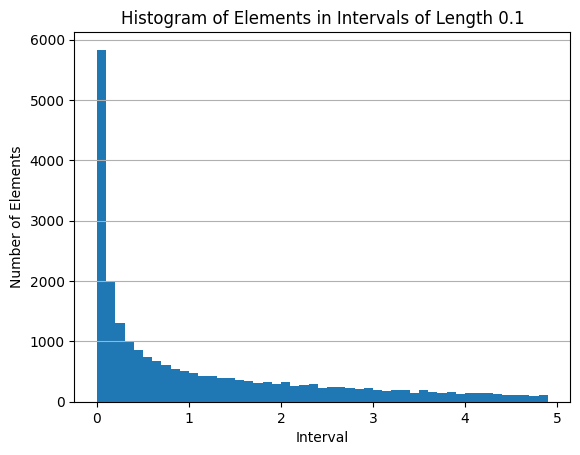

In [16]:
import matplotlib.pyplot as plt
# Create bins with intervals of length 0.1
bins = [i / 10 for i in range(50)]

# Use pd.cut to bin the data into intervals
interval_counts = pd.cut(output, bins=bins, right=False).value_counts(sort=False)

# Plot the histogram
interval_index = pd.IntervalIndex(interval_counts.index)
left_endpoints = interval_index.left

# Plot the histogram
plt.bar(left_endpoints, interval_counts.values, width=0.1, align='edge')
plt.xlabel('Interval')
plt.ylabel('Number of Elements')
plt.title('Histogram of Elements in Intervals of Length 0.1')
plt.grid(axis='y')
plt.show()

Features: Approach I:

In [17]:
#Time to maturity
data['Expiry'] = pd.to_datetime(data['Expiry'])
date_difference = data['Expiry'] - data['Date']
data['Time to maturiy'] = date_difference
Moneyness=data['Underlying Value']/data['Strike Price']
data['Moneyness'] = Moneyness
data

,Symbol,Date,Expiry,Option type,Strike Price,Open,High,Low,Close,LTP,...,A day before_Close,last20_Close,last20_Open,last20_High,last20_Low,government bond yield rate,Output,category,Time to maturiy,Moneyness
0,BANKNIFTY,2015-01-02,2015-01-29,CE,20200.0,46.45,82.75,46.45,69.65,73.0,...,0.002208,"[18,750.45, 18,736.65, 18,647.55, 18,528.35, 1...","[18,728.20, 18,659.60, 18,573.25, 18,589.60, 1...","[18,781.55, 18,774.20, 18,671.95, 18,700.70, 1...","[18,638.85, 18,659.60, 18,428.10, 18,501.05, 1...",8.3,0.344802,3,27 days,0.943455
1,BANKNIFTY,2015-01-02,2015-01-29,CE,20400.0,27.00,54.00,26.05,45.25,47.0,...,0.001230,"[18,750.45, 18,736.65, 18,647.55, 18,528.35, 1...","[18,728.20, 18,659.60, 18,573.25, 18,589.60, 1...","[18,781.55, 18,774.20, 18,671.95, 18,700.70, 1...","[18,638.85, 18,659.60, 18,428.10, 18,501.05, 1...",8.3,0.221814,2,27 days,0.934206
2,BANKNIFTY,2015-01-02,2015-01-29,CE,20100.0,59.95,98.95,58.65,90.00,94.0,...,0.002465,"[18,750.45, 18,736.65, 18,647.55, 18,528.35, 1...","[18,728.20, 18,659.60, 18,573.25, 18,589.60, 1...","[18,781.55, 18,774.20, 18,671.95, 18,700.70, 1...","[18,638.85, 18,659.60, 18,428.10, 18,501.05, 1...",8.3,0.447761,4,27 days,0.948149
3,BANKNIFTY,2015-01-02,2015-01-29,CE,20000.0,51.40,120.00,51.40,105.95,110.0,...,0.003065,"[18,750.45, 18,736.65, 18,647.55, 18,528.35, 1...","[18,728.20, 18,659.60, 18,573.25, 18,589.60, 1...","[18,781.55, 18,774.20, 18,671.95, 18,700.70, 1...","[18,638.85, 18,659.60, 18,428.10, 18,501.05, 1...",8.3,0.529750,5,27 days,0.952890
4,BANKNIFTY,2015-01-02,2015-01-29,CE,19900.0,81.00,145.00,80.00,128.45,131.0,...,0.003784,"[18,750.45, 18,736.65, 18,647.55, 18,528.35, 1...","[18,728.20, 18,659.60, 18,573.25, 18,589.60, 1...","[18,781.55, 18,774.20, 18,671.95, 18,700.70, 1...","[18,638.85, 18,659.60, 18,428.10, 18,501.05, 1...",8.3,0.645477,6,27 days,0.957678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27833,BANKNIFTY,2018-12-13,2018-12-27,CE,28300.0,8.15,16.05,8.15,14.70,14.7,...,0.000383,"[26,643.85, 26,163.40, 26,102.65, 26,594.30, 2...","[26,286.25, 25,602.25, 26,073.65, 26,307.40, 2...","[26,672.70, 26,227.90, 26,336.20, 26,659.70, 2...","[26,214.75, 25,598.95, 26,072.00, 26,252.10, 2...",6.7,0.051943,0,14 days,0.947574
27834,BANKNIFTY,2018-12-13,2018-12-27,CE,28400.0,8.00,11.55,6.55,8.85,8.6,...,0.000324,"[26,643.85, 26,163.40, 26,102.65, 26,594.30, 2...","[26,286.25, 25,602.25, 26,073.65, 26,307.40, 2...","[26,672.70, 26,227.90, 26,336.20, 26,659.70, 2...","[26,214.75, 25,598.95, 26,072.00, 26,252.10, 2...",6.7,0.031162,0,14 days,0.944238
27835,BANKNIFTY,2018-12-13,2018-12-27,CE,28500.0,6.80,10.20,6.40,7.75,6.4,...,0.000261,"[26,643.85, 26,163.40, 26,102.65, 26,594.30, 2...","[26,286.25, 25,602.25, 26,073.65, 26,307.40, 2...","[26,672.70, 26,227.90, 26,336.20, 26,659.70, 2...","[26,214.75, 25,598.95, 26,072.00, 26,252.10, 2...",6.7,0.027193,0,14 days,0.940925
27836,BANKNIFTY,2018-12-13,2018-12-27,CE,28000.0,22.35,35.00,18.60,23.30,22.0,...,0.000736,"[26,643.85, 26,163.40, 26,102.65, 26,594.30, 2...","[26,286.25, 25,602.25, 26,073.65, 26,307.40, 2...","[26,672.70, 26,227.90, 26,336.20, 26,659.70, 2...","[26,214.75, 25,598.95, 26,072.00, 26,252.10, 2...",6.7,0.083214,0,14 days,0.957727


In [18]:
data = data.reset_index(drop=True)

Order statistics:
assuming that we have an array containing the past 20 trading days values

In [19]:
import numpy as np

def logreturn(L):
    for j in range(len(L)-1):
        L[j]=np.log(L[j+1]/L[j])
    L.pop() 
    return(L)

In [20]:
data['19_order_returns']=None
p=0
for i in data['last20_Close']:
    i = [float(value.replace(',', '')) for value in i]
    i=logreturn(i)
    i.sort()
    data.at[p, '19_order_returns'] = i
    p+=1
data

,Symbol,Date,Expiry,Option type,Strike Price,Open,High,Low,Close,LTP,...,last20_Close,last20_Open,last20_High,last20_Low,government bond yield rate,Output,category,Time to maturiy,Moneyness,19_order_returns
0,BANKNIFTY,2015-01-02,2015-01-29,CE,20200.0,46.45,82.75,46.45,69.65,73.0,...,"[18,750.45, 18,736.65, 18,647.55, 18,528.35, 1...","[18,728.20, 18,659.60, 18,573.25, 18,589.60, 1...","[18,781.55, 18,774.20, 18,671.95, 18,700.70, 1...","[18,638.85, 18,659.60, 18,428.10, 18,501.05, 1...",8.3,0.344802,3,27 days,0.943455,"[-0.02546808425364105, -0.014422868462187556, ..."
1,BANKNIFTY,2015-01-02,2015-01-29,CE,20400.0,27.00,54.00,26.05,45.25,47.0,...,"[18,750.45, 18,736.65, 18,647.55, 18,528.35, 1...","[18,728.20, 18,659.60, 18,573.25, 18,589.60, 1...","[18,781.55, 18,774.20, 18,671.95, 18,700.70, 1...","[18,638.85, 18,659.60, 18,428.10, 18,501.05, 1...",8.3,0.221814,2,27 days,0.934206,"[-0.02546808425364105, -0.014422868462187556, ..."
2,BANKNIFTY,2015-01-02,2015-01-29,CE,20100.0,59.95,98.95,58.65,90.00,94.0,...,"[18,750.45, 18,736.65, 18,647.55, 18,528.35, 1...","[18,728.20, 18,659.60, 18,573.25, 18,589.60, 1...","[18,781.55, 18,774.20, 18,671.95, 18,700.70, 1...","[18,638.85, 18,659.60, 18,428.10, 18,501.05, 1...",8.3,0.447761,4,27 days,0.948149,"[-0.02546808425364105, -0.014422868462187556, ..."
3,BANKNIFTY,2015-01-02,2015-01-29,CE,20000.0,51.40,120.00,51.40,105.95,110.0,...,"[18,750.45, 18,736.65, 18,647.55, 18,528.35, 1...","[18,728.20, 18,659.60, 18,573.25, 18,589.60, 1...","[18,781.55, 18,774.20, 18,671.95, 18,700.70, 1...","[18,638.85, 18,659.60, 18,428.10, 18,501.05, 1...",8.3,0.529750,5,27 days,0.952890,"[-0.02546808425364105, -0.014422868462187556, ..."
4,BANKNIFTY,2015-01-02,2015-01-29,CE,19900.0,81.00,145.00,80.00,128.45,131.0,...,"[18,750.45, 18,736.65, 18,647.55, 18,528.35, 1...","[18,728.20, 18,659.60, 18,573.25, 18,589.60, 1...","[18,781.55, 18,774.20, 18,671.95, 18,700.70, 1...","[18,638.85, 18,659.60, 18,428.10, 18,501.05, 1...",8.3,0.645477,6,27 days,0.957678,"[-0.02546808425364105, -0.014422868462187556, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27833,BANKNIFTY,2018-12-13,2018-12-27,CE,28300.0,8.15,16.05,8.15,14.70,14.7,...,"[26,643.85, 26,163.40, 26,102.65, 26,594.30, 2...","[26,286.25, 25,602.25, 26,073.65, 26,307.40, 2...","[26,672.70, 26,227.90, 26,336.20, 26,659.70, 2...","[26,214.75, 25,598.95, 26,072.00, 26,252.10, 2...",6.7,0.051943,0,14 days,0.947574,"[-0.018196867187103026, -0.01804064281122521, ..."
27834,BANKNIFTY,2018-12-13,2018-12-27,CE,28400.0,8.00,11.55,6.55,8.85,8.6,...,"[26,643.85, 26,163.40, 26,102.65, 26,594.30, 2...","[26,286.25, 25,602.25, 26,073.65, 26,307.40, 2...","[26,672.70, 26,227.90, 26,336.20, 26,659.70, 2...","[26,214.75, 25,598.95, 26,072.00, 26,252.10, 2...",6.7,0.031162,0,14 days,0.944238,"[-0.018196867187103026, -0.01804064281122521, ..."
27835,BANKNIFTY,2018-12-13,2018-12-27,CE,28500.0,6.80,10.20,6.40,7.75,6.4,...,"[26,643.85, 26,163.40, 26,102.65, 26,594.30, 2...","[26,286.25, 25,602.25, 26,073.65, 26,307.40, 2...","[26,672.70, 26,227.90, 26,336.20, 26,659.70, 2...","[26,214.75, 25,598.95, 26,072.00, 26,252.10, 2...",6.7,0.027193,0,14 days,0.940925,"[-0.018196867187103026, -0.01804064281122521, ..."
27836,BANKNIFTY,2018-12-13,2018-12-27,CE,28000.0,22.35,35.00,18.60,23.30,22.0,...,"[26,643.85, 26,163.40, 26,102.65, 26,594.30, 2...","[26,286.25, 25,602.25, 26,073.65, 26,307.40, 2...","[26,672.70, 26,227.90, 26,336.20, 26,659.70, 2...","[26,214.75, 25,598.95, 26,072.00, 26,252.10, 2...",6.7,0.083214,0,14 days,0.957727,"[-0.018196867187103026, -0.01804064281122521, ..."


In [72]:
Approach1_dataset=data[['19_order_returns','Moneyness','Time to maturiy','government bond yield rate']]
Approach1_dataset.dtypes

Moneyness                     float64
government bond yield rate    float64
Time to maturity (days)         int64
logreturn_n 0                 float64
logreturn_n 1                 float64
logreturn_n 2                 float64
logreturn_n 3                 float64
logreturn_n 4                 float64
logreturn_n 5                 float64
logreturn_n 6                 float64
logreturn_n 7                 float64
logreturn_n 8                 float64
logreturn_n 9                 float64
logreturn_n 10                float64
logreturn_n 11                float64
logreturn_n 12                float64
logreturn_n 13                float64
logreturn_n 14                float64
logreturn_n 15                float64
logreturn_n 16                float64
logreturn_n 17                float64
logreturn_n 18                float64
dtype: object

In [68]:
for i in range(19):
    column_name = f'logreturn_n {i}'
    Approach1_dataset[column_name] = None
for i in range(len(Approach1_dataset)):
    for j in range(19):
        column_name = f'logreturn_n {j}'
        L=Approach1_dataset.loc[i,'19_order_returns']
        Approach1_dataset.at[i, column_name] = L[j]

C:\Users\thous\AppData\Local\Temp\ipykernel_26560\229496390.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Approach1_dataset[column_name] = None


In [69]:
Approach1_dataset = Approach1_dataset.drop(columns=['19_order_returns'])

In [70]:
for i in range(19):
    column_name = f'logreturn_n {i}'
    Approach1_dataset[column_name] = Approach1_dataset[column_name].astype(float)
Approach1_dataset

,Moneyness,government bond yield rate,Time to maturity (days),logreturn_n 0,logreturn_n 1,logreturn_n 2,logreturn_n 3,logreturn_n 4,logreturn_n 5,logreturn_n 6,...,logreturn_n 9,logreturn_n 10,logreturn_n 11,logreturn_n 12,logreturn_n 13,logreturn_n 14,logreturn_n 15,logreturn_n 16,logreturn_n 17,logreturn_n 18
0,0.943455,8.3,27,-0.025468,-0.014423,-0.009376,-0.008276,-0.006413,-0.004767,-0.003976,...,-0.000736,0.001391,0.001556,0.003144,0.003683,0.005735,0.007689,0.011924,0.01324,0.02995
1,0.934206,8.3,27,-0.025468,-0.014423,-0.009376,-0.008276,-0.006413,-0.004767,-0.003976,...,-0.000736,0.001391,0.001556,0.003144,0.003683,0.005735,0.007689,0.011924,0.01324,0.02995
2,0.948149,8.3,27,-0.025468,-0.014423,-0.009376,-0.008276,-0.006413,-0.004767,-0.003976,...,-0.000736,0.001391,0.001556,0.003144,0.003683,0.005735,0.007689,0.011924,0.01324,0.02995
3,0.952890,8.3,27,-0.025468,-0.014423,-0.009376,-0.008276,-0.006413,-0.004767,-0.003976,...,-0.000736,0.001391,0.001556,0.003144,0.003683,0.005735,0.007689,0.011924,0.01324,0.02995
4,0.957678,8.3,27,-0.025468,-0.014423,-0.009376,-0.008276,-0.006413,-0.004767,-0.003976,...,-0.000736,0.001391,0.001556,0.003144,0.003683,0.005735,0.007689,0.011924,0.01324,0.02995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27833,0.947574,6.7,14,-0.018197,-0.018041,-0.015002,-0.013985,-0.008624,-0.005678,-0.003466,...,-0.002099,-0.000561,0.000201,0.002849,0.006116,0.006547,0.007149,0.010050,0.01219,0.01866
27834,0.944238,6.7,14,-0.018197,-0.018041,-0.015002,-0.013985,-0.008624,-0.005678,-0.003466,...,-0.002099,-0.000561,0.000201,0.002849,0.006116,0.006547,0.007149,0.010050,0.01219,0.01866
27835,0.940925,6.7,14,-0.018197,-0.018041,-0.015002,-0.013985,-0.008624,-0.005678,-0.003466,...,-0.002099,-0.000561,0.000201,0.002849,0.006116,0.006547,0.007149,0.010050,0.01219,0.01866
27836,0.957727,6.7,14,-0.018197,-0.018041,-0.015002,-0.013985,-0.008624,-0.005678,-0.003466,...,-0.002099,-0.000561,0.000201,0.002849,0.006116,0.006547,0.007149,0.010050,0.01219,0.01866


Approach II:

In [25]:
#logreturns for last 20 days' Close

data['Close_Log_returns']=None
p=0
for i in data['last20_Close']:
    i = [float(value.replace(',', '')) for value in i]
    i=logreturn(i)
    data.at[p, 'Close_Log_returns'] = i
    p+=1
#logreturns for last 20 days' Open

data['Open_Log_returns']=None
p=0
for i in data['last20_Open']:
    i = [float(value.replace(',', '')) for value in i]
    i=logreturn(i)
    data.at[p, 'Open_Log_returns'] = i
    p+=1

#logreturns for last 20 days' high
data['High_Log_returns']=None
p=0
for i in data['last20_High']:
    i = [float(value.replace(',', '')) for value in i]
    i=logreturn(i)
    data.at[p, 'High_Log_returns'] = i
    p+=1
#logreturns for last 20 days' Low
data['Low_Log_returns']=None
p=0
for i in data['last20_Low']:
    i = [float(value.replace(',', '')) for value in i]
    i=logreturn(i)
    data.at[p, 'Low_Log_returns'] = i
    p+=1


In [26]:
#Arithmetic means:
#logreturns for last 20 days' Open

data['mean_of_Open']=None
p=0
for i in data['Open_Log_returns']:
    i=np.mean(i)
    data.at[p, 'mean_of_Open'] = i
    p+=1

#logreturns for last 20 days' High

data['mean_of_High']=None
p=0
for i in data['High_Log_returns']:
    i=np.mean(i)
    data.at[p, 'mean_of_High'] = i
    p+=1

#logreturns for last 20 days' Low

data['mean_of_low']=None
p=0
for i in data['Low_Log_returns']:
    i=np.mean(i)
    data.at[p, 'mean_of_low'] = i
    p+=1

#logreturns for last 20 days' Close

data['mean_of_Close']=None
p=0
for i in data['Close_Log_returns']:
    i=np.mean(i)
    data.at[p, 'mean_of_Close'] = i
    p+=1
data

,Symbol,Date,Expiry,Option type,Strike Price,Open,High,Low,Close,LTP,...,Moneyness,19_order_returns,Close_Log_returns,Open_Log_returns,High_Log_returns,Low_Log_returns,mean_of_Open,mean_of_High,mean_of_low,mean_of_Close
0,BANKNIFTY,2015-01-02,2015-01-29,CE,20200.0,46.45,82.75,46.45,69.65,73.0,...,0.943455,"[-0.02546808425364105, -0.014422868462187556, ...","[-0.0007362533043835887, -0.004766728655880122...","[-0.0036696503662973275, -0.004638385448095363...","[-0.000391418096767517, -0.005461189154570435,...","[0.0011126468869714524, -0.012484085378414103,...",8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05
1,BANKNIFTY,2015-01-02,2015-01-29,CE,20400.0,27.00,54.00,26.05,45.25,47.0,...,0.934206,"[-0.02546808425364105, -0.014422868462187556, ...","[-0.0007362533043835887, -0.004766728655880122...","[-0.0036696503662973275, -0.004638385448095363...","[-0.000391418096767517, -0.005461189154570435,...","[0.0011126468869714524, -0.012484085378414103,...",8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05
2,BANKNIFTY,2015-01-02,2015-01-29,CE,20100.0,59.95,98.95,58.65,90.00,94.0,...,0.948149,"[-0.02546808425364105, -0.014422868462187556, ...","[-0.0007362533043835887, -0.004766728655880122...","[-0.0036696503662973275, -0.004638385448095363...","[-0.000391418096767517, -0.005461189154570435,...","[0.0011126468869714524, -0.012484085378414103,...",8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05
3,BANKNIFTY,2015-01-02,2015-01-29,CE,20000.0,51.40,120.00,51.40,105.95,110.0,...,0.952890,"[-0.02546808425364105, -0.014422868462187556, ...","[-0.0007362533043835887, -0.004766728655880122...","[-0.0036696503662973275, -0.004638385448095363...","[-0.000391418096767517, -0.005461189154570435,...","[0.0011126468869714524, -0.012484085378414103,...",8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05
4,BANKNIFTY,2015-01-02,2015-01-29,CE,19900.0,81.00,145.00,80.00,128.45,131.0,...,0.957678,"[-0.02546808425364105, -0.014422868462187556, ...","[-0.0007362533043835887, -0.004766728655880122...","[-0.0036696503662973275, -0.004638385448095363...","[-0.000391418096767517, -0.005461189154570435,...","[0.0011126468869714524, -0.012484085378414103,...",8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27833,BANKNIFTY,2018-12-13,2018-12-27,CE,28300.0,8.15,16.05,8.15,14.70,14.7,...,0.947574,"[-0.018196867187103026, -0.01804064281122521, ...","[-0.018196867187103026, -0.0023246458210496677...","[-0.026365750532414592, 0.018244987568542186, ...","[-0.016816840740227254, 0.0041206889586298074,...","[-0.02377089443477976, 0.018310606515907338, 0...",-0.000672731,-0.00125331,-0.000825688,-0.00142905
27834,BANKNIFTY,2018-12-13,2018-12-27,CE,28400.0,8.00,11.55,6.55,8.85,8.6,...,0.944238,"[-0.018196867187103026, -0.01804064281122521, ...","[-0.018196867187103026, -0.0023246458210496677...","[-0.026365750532414592, 0.018244987568542186, ...","[-0.016816840740227254, 0.0041206889586298074,...","[-0.02377089443477976, 0.018310606515907338, 0...",-0.000672731,-0.00125331,-0.000825688,-0.00142905
27835,BANKNIFTY,2018-12-13,2018-12-27,CE,28500.0,6.80,10.20,6.40,7.75,6.4,...,0.940925,"[-0.018196867187103026, -0.01804064281122521, ...","[-0.018196867187103026, -0.0023246458210496677...","[-0.026365750532414592, 0.018244987568542186, ...","[-0.016816840740227254, 0.0041206889586298074,...","[-0.02377089443477976, 0.018310606515907338, 0...",-0.000672731,-0.00125331,-0.000825688,-0.00142905
27836,BANKNIFTY,2018-12-13,2018-12-27,CE,28000.0,22.35,35.00,18.60,23.30,22.0,...,0.957727,"[-0.018196867187103026, -0.01804064281122521, ...","[-0.018196867187103026, -0.0023246458210496677...","[-0.026365750532414592, 0.018244987568542186, ...","[-0.016816840740227254, 0.0041206889586298074,...","[-0.02377089443477976, 0.018310606515907338, 0...",-0.000672731,-0.00125331,-0.000825688,-0.00142905


In [27]:
def cov_statistics(cov_matrix):
    s=cov_matrix.shape
    for i in range(s[0]):
        for j in range(s[1]):
            if cov_matrix[i,j]==0:
                cov_matrix[i,j]=0
            else:
                cov_matrix[i,j]=(cov_matrix[i,j])/np.sqrt(abs(cov_matrix[i,j]))
    cov_matrix= cov_matrix[np.triu_indices(len(cov_matrix), k=0)]
    return(cov_matrix)
    
data['Covariance']=None
p=0
for i in range(len(data)):
    x=data.loc[i, 'Open_Log_returns']
    y=data.loc[i, 'High_Log_returns']
    v=data.loc[i, 'Low_Log_returns']
    w=data.loc[i, 'Close_Log_returns']
    data_matrix = np.vstack((x, y, v, w))
    covariance_matrix = np.cov(data_matrix)
    covar = cov_statistics(covariance_matrix)
    data.at[i, 'Covariance'] = covar

data


,Symbol,Date,Expiry,Option type,Strike Price,Open,High,Low,Close,LTP,...,19_order_returns,Close_Log_returns,Open_Log_returns,High_Log_returns,Low_Log_returns,mean_of_Open,mean_of_High,mean_of_low,mean_of_Close,Covariance
0,BANKNIFTY,2015-01-02,2015-01-29,CE,20200.0,46.45,82.75,46.45,69.65,73.0,...,"[-0.02546808425364105, -0.014422868462187556, ...","[-0.0007362533043835887, -0.004766728655880122...","[-0.0036696503662973275, -0.004638385448095363...","[-0.000391418096767517, -0.005461189154570435,...","[0.0011126468869714524, -0.012484085378414103,...",8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05,"[0.012617416653987119, 0.009010710831182439, 0..."
1,BANKNIFTY,2015-01-02,2015-01-29,CE,20400.0,27.00,54.00,26.05,45.25,47.0,...,"[-0.02546808425364105, -0.014422868462187556, ...","[-0.0007362533043835887, -0.004766728655880122...","[-0.0036696503662973275, -0.004638385448095363...","[-0.000391418096767517, -0.005461189154570435,...","[0.0011126468869714524, -0.012484085378414103,...",8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05,"[0.012617416653987119, 0.009010710831182439, 0..."
2,BANKNIFTY,2015-01-02,2015-01-29,CE,20100.0,59.95,98.95,58.65,90.00,94.0,...,"[-0.02546808425364105, -0.014422868462187556, ...","[-0.0007362533043835887, -0.004766728655880122...","[-0.0036696503662973275, -0.004638385448095363...","[-0.000391418096767517, -0.005461189154570435,...","[0.0011126468869714524, -0.012484085378414103,...",8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05,"[0.012617416653987119, 0.009010710831182439, 0..."
3,BANKNIFTY,2015-01-02,2015-01-29,CE,20000.0,51.40,120.00,51.40,105.95,110.0,...,"[-0.02546808425364105, -0.014422868462187556, ...","[-0.0007362533043835887, -0.004766728655880122...","[-0.0036696503662973275, -0.004638385448095363...","[-0.000391418096767517, -0.005461189154570435,...","[0.0011126468869714524, -0.012484085378414103,...",8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05,"[0.012617416653987119, 0.009010710831182439, 0..."
4,BANKNIFTY,2015-01-02,2015-01-29,CE,19900.0,81.00,145.00,80.00,128.45,131.0,...,"[-0.02546808425364105, -0.014422868462187556, ...","[-0.0007362533043835887, -0.004766728655880122...","[-0.0036696503662973275, -0.004638385448095363...","[-0.000391418096767517, -0.005461189154570435,...","[0.0011126468869714524, -0.012484085378414103,...",8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05,"[0.012617416653987119, 0.009010710831182439, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27833,BANKNIFTY,2018-12-13,2018-12-27,CE,28300.0,8.15,16.05,8.15,14.70,14.7,...,"[-0.018196867187103026, -0.01804064281122521, ...","[-0.018196867187103026, -0.0023246458210496677...","[-0.026365750532414592, 0.018244987568542186, ...","[-0.016816840740227254, 0.0041206889586298074,...","[-0.02377089443477976, 0.018310606515907338, 0...",-0.000672731,-0.00125331,-0.000825688,-0.00142905,"[0.010266462133796265, 0.0075372546430859414, ..."
27834,BANKNIFTY,2018-12-13,2018-12-27,CE,28400.0,8.00,11.55,6.55,8.85,8.6,...,"[-0.018196867187103026, -0.01804064281122521, ...","[-0.018196867187103026, -0.0023246458210496677...","[-0.026365750532414592, 0.018244987568542186, ...","[-0.016816840740227254, 0.0041206889586298074,...","[-0.02377089443477976, 0.018310606515907338, 0...",-0.000672731,-0.00125331,-0.000825688,-0.00142905,"[0.010266462133796265, 0.0075372546430859414, ..."
27835,BANKNIFTY,2018-12-13,2018-12-27,CE,28500.0,6.80,10.20,6.40,7.75,6.4,...,"[-0.018196867187103026, -0.01804064281122521, ...","[-0.018196867187103026, -0.0023246458210496677...","[-0.026365750532414592, 0.018244987568542186, ...","[-0.016816840740227254, 0.0041206889586298074,...","[-0.02377089443477976, 0.018310606515907338, 0...",-0.000672731,-0.00125331,-0.000825688,-0.00142905,"[0.010266462133796265, 0.0075372546430859414, ..."
27836,BANKNIFTY,2018-12-13,2018-12-27,CE,28000.0,22.35,35.00,18.60,23.30,22.0,...,"[-0.018196867187103026, -0.01804064281122521, ...","[-0.018196867187103026, -0.002324

In [28]:
Approach2_dataset=data[['mean_of_Open','mean_of_High','mean_of_low','mean_of_Close','Covariance','Moneyness','government bond yield rate']]
Approach2_dataset

,mean_of_Open,mean_of_High,mean_of_low,mean_of_Close,Covariance,Moneyness,government bond yield rate
0,8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05,"[0.012617416653987119, 0.009010710831182439, 0...",0.943455,8.3
1,8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05,"[0.012617416653987119, 0.009010710831182439, 0...",0.934206,8.3
2,8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05,"[0.012617416653987119, 0.009010710831182439, 0...",0.948149,8.3
3,8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05,"[0.012617416653987119, 0.009010710831182439, 0...",0.952890,8.3
4,8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05,"[0.012617416653987119, 0.009010710831182439, 0...",0.957678,8.3
...,...,...,...,...,...,...,...
27833,-0.000672731,-0.00125331,-0.000825688,-0.00142905,"[0.010266462133796265, 0.0075372546430859414, ...",0.947574,6.7
27834,-0.000672731,-0.00125331,-0.000825688,-0.00142905,"[0.010266462133796265, 0.0075372546430859414, ...",0.944238,6.7
27835,-0.000672731,-0.00125331,-0.000825688,-0.00142905,"[0.010266462133796265, 0.0075372546430859414, ...",0.940925,6.7
27836,-0.000672731,-0.00125331,-0.000825688,-0.00142905,"[0.010266462133796265, 0.0075372546430859414, ...",0.957727,6.7


Approach III:

In [29]:
#Mean moneyness
data['Mean_Moneyness']=None
p=0
for i in data['last20_Close']:
    i = [float(value.replace(',', '')) for value in i]
    i=np.mean(i)
    data.at[p, 'Mean_Moneyness'] = i/data.loc[p,'Strike Price']
    p+=1
data

,Symbol,Date,Expiry,Option type,Strike Price,Open,High,Low,Close,LTP,...,Close_Log_returns,Open_Log_returns,High_Log_returns,Low_Log_returns,mean_of_Open,mean_of_High,mean_of_low,mean_of_Close,Covariance,Mean_Moneyness
0,BANKNIFTY,2015-01-02,2015-01-29,CE,20200.0,46.45,82.75,46.45,69.65,73.0,...,"[-0.0007362533043835887, -0.004766728655880122...","[-0.0036696503662973275, -0.004638385448095363...","[-0.000391418096767517, -0.005461189154570435,...","[0.0011126468869714524, -0.012484085378414103,...",8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05,"[0.012617416653987119, 0.009010710831182439, 0...",0.914577
1,BANKNIFTY,2015-01-02,2015-01-29,CE,20400.0,27.00,54.00,26.05,45.25,47.0,...,"[-0.0007362533043835887, -0.004766728655880122...","[-0.0036696503662973275, -0.004638385448095363...","[-0.000391418096767517, -0.005461189154570435,...","[0.0011126468869714524, -0.012484085378414103,...",8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05,"[0.012617416653987119, 0.009010710831182439, 0...",0.905611
2,BANKNIFTY,2015-01-02,2015-01-29,CE,20100.0,59.95,98.95,58.65,90.00,94.0,...,"[-0.0007362533043835887, -0.004766728655880122...","[-0.0036696503662973275, -0.004638385448095363...","[-0.000391418096767517, -0.005461189154570435,...","[0.0011126468869714524, -0.012484085378414103,...",8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05,"[0.012617416653987119, 0.009010710831182439, 0...",0.919127
3,BANKNIFTY,2015-01-02,2015-01-29,CE,20000.0,51.40,120.00,51.40,105.95,110.0,...,"[-0.0007362533043835887, -0.004766728655880122...","[-0.0036696503662973275, -0.004638385448095363...","[-0.000391418096767517, -0.005461189154570435,...","[0.0011126468869714524, -0.012484085378414103,...",8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05,"[0.012617416653987119, 0.009010710831182439, 0...",0.923723
4,BANKNIFTY,2015-01-02,2015-01-29,CE,19900.0,81.00,145.00,80.00,128.45,131.0,...,"[-0.0007362533043835887, -0.004766728655880122...","[-0.0036696503662973275, -0.004638385448095363...","[-0.000391418096767517, -0.005461189154570435,...","[0.0011126468869714524, -0.012484085378414103,...",8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05,"[0.012617416653987119, 0.009010710831182439, 0...",0.928365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27833,BANKNIFTY,2018-12-13,2018-12-27,CE,28300.0,8.15,16.05,8.15,14.70,14.7,...,"[-0.018196867187103026, -0.0023246458210496677...","[-0.026365750532414592, 0.018244987568542186, ...","[-0.016816840740227254, 0.0041206889586298074,...","[-0.02377089443477976, 0.018310606515907338, 0...",-0.000672731,-0.00125331,-0.000825688,-0.00142905,"[0.010266462133796265, 0.0075372546430859414, ...",0.932595
27834,BANKNIFTY,2018-12-13,2018-12-27,CE,28400.0,8.00,11.55,6.55,8.85,8.6,...,"[-0.018196867187103026, -0.0023246458210496677...","[-0.026365750532414592, 0.018244987568542186, ...","[-0.016816840740227254, 0.0041206889586298074,...","[-0.02377089443477976, 0.018310606515907338, 0...",-0.000672731,-0.00125331,-0.000825688,-0.00142905,"[0.010266462133796265, 0.0075372546430859414, ...",0.929311
27835,BANKNIFTY,2018-12-13,2018-12-27,CE,28500.0,6.80,10.20,6.40,7.75,6.4,...,"[-0.018196867187103026, -0.0023246458210496677...","[-0.026365750532414592, 0.018244987568542186, ...","[-0.016816840740227254, 0.0041206889586298074,...","[-0.02377089443477976, 0.018310606515907338, 0...",-0.000672731,-0.00125331,-0.000825688,-0.00142905,"[0.010266462133796265, 0.0075372546430859414, ...",0.92605
27836,BANKNIFTY,2018-12-13,2018-12-27,CE,28000.0,22.35,35.00,18.60,23.30,22.0,...,"[-0.018196867187103026, -0.0023246458210496677...","[-0.026365750532414592, 0.018244987568542186, ...","[-0.016816840740227254, 0.0041206889586298074,...","[-0.02377089443477976, 0.018310606515907338, 0...",-0.000672731,-0.00125331,-0.000825688,-0.00142905,"[0.010266462133796265, 0.0075372546430859414, ...",0.942587


In [30]:
Approach3_dataset=data[['A day before_Close','Mean_Moneyness','Moneyness','Time to maturiy','government bond yield rate','mean_of_Open','mean_of_High','mean_of_low','mean_of_Close','Covariance']]
Approach3_dataset

,A day before_Close,Mean_Moneyness,Moneyness,Time to maturiy,government bond yield rate,mean_of_Open,mean_of_High,mean_of_low,mean_of_Close,Covariance
0,0.002208,0.914577,0.943455,27 days,8.3,8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05,"[0.012617416653987119, 0.009010710831182439, 0..."
1,0.001230,0.905611,0.934206,27 days,8.3,8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05,"[0.012617416653987119, 0.009010710831182439, 0..."
2,0.002465,0.919127,0.948149,27 days,8.3,8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05,"[0.012617416653987119, 0.009010710831182439, 0..."
3,0.003065,0.923723,0.952890,27 days,8.3,8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05,"[0.012617416653987119, 0.009010710831182439, 0..."
4,0.003784,0.928365,0.957678,27 days,8.3,8.59245e-05,3.24967e-05,-0.000179615,9.08667e-05,"[0.012617416653987119, 0.009010710831182439, 0..."
...,...,...,...,...,...,...,...,...,...,...
27833,0.000383,0.932595,0.947574,14 days,6.7,-0.000672731,-0.00125331,-0.000825688,-0.00142905,"[0.010266462133796265, 0.0075372546430859414, ..."
27834,0.000324,0.929311,0.944238,14 days,6.7,-0.000672731,-0.00125331,-0.000825688,-0.00142905,"[0.010266462133796265, 0.0075372546430859414, ..."
27835,0.000261,0.92605,0.940925,14 days,6.7,-0.000672731,-0.00125331,-0.000825688,-0.00142905,"[0.010266462133796265, 0.0075372546430859414, ..."
27836,0.000736,0.942587,0.957727,14 days,6.7,-0.000672731,-0.00125331,-0.000825688,-0.00142905,"[0.010266462133796265, 0.0075372546430859414, ..."


# Machine Learning

In [31]:
y=
x=

In [51]:
# Data manipulation
import pandas as pd  # for data manipulation
print('pandas:', pd.__version__)  # print version
import numpy as np  # for data manipulation
print('numpy:', np.__version__)  # print version

# Sklearn
import sklearn  # for model evaluation
print('sklearn:', sklearn.__version__)  # print version
from sklearn.model_selection import train_test_split  # for splitting data into train and test samples
from sklearn.metrics import classification_report  # for model evaluation metrics

# Tensorflow / Keras
from tensorflow import keras  # for building Neural Networks
print('Tensorflow/Keras:', keras.__version__)  # print version
from keras.models import Sequential  # for creating a linear stack of layers for our Neural Network
from keras import Input  # for instantiating a keras tensor
from keras.layers import Dense  # for creating regular densely-connected NN layers.


pandas: 1.1.3
numpy: 1.20.1
sklearn: 1.3.0
Tensorflow/Keras: 2.4.0


Feed_forward neural networks

In [ ]:
Approach1_dataset['Time to maturity (days)'] = Approach1_dataset['Time to maturiy'].dt.days

Approach1_dataset.drop(columns=['Time to maturiy'], inplace=True)

Approach1_dataset

In [84]:
Approach1_dataset

,Moneyness,government bond yield rate,Time to maturity (days),logreturn_n 0,logreturn_n 1,logreturn_n 2,logreturn_n 3,logreturn_n 4,logreturn_n 5,logreturn_n 6,...,logreturn_n 9,logreturn_n 10,logreturn_n 11,logreturn_n 12,logreturn_n 13,logreturn_n 14,logreturn_n 15,logreturn_n 16,logreturn_n 17,logreturn_n 18
0,0.943455,8.3,27,-0.025468,-0.014423,-0.009376,-0.008276,-0.006413,-0.004767,-0.003976,...,-0.000736,0.001391,0.001556,0.003144,0.003683,0.005735,0.007689,0.011924,0.01324,0.02995
1,0.934206,8.3,27,-0.025468,-0.014423,-0.009376,-0.008276,-0.006413,-0.004767,-0.003976,...,-0.000736,0.001391,0.001556,0.003144,0.003683,0.005735,0.007689,0.011924,0.01324,0.02995
2,0.948149,8.3,27,-0.025468,-0.014423,-0.009376,-0.008276,-0.006413,-0.004767,-0.003976,...,-0.000736,0.001391,0.001556,0.003144,0.003683,0.005735,0.007689,0.011924,0.01324,0.02995
3,0.952890,8.3,27,-0.025468,-0.014423,-0.009376,-0.008276,-0.006413,-0.004767,-0.003976,...,-0.000736,0.001391,0.001556,0.003144,0.003683,0.005735,0.007689,0.011924,0.01324,0.02995
4,0.957678,8.3,27,-0.025468,-0.014423,-0.009376,-0.008276,-0.006413,-0.004767,-0.003976,...,-0.000736,0.001391,0.001556,0.003144,0.003683,0.005735,0.007689,0.011924,0.01324,0.02995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27833,0.947574,6.7,14,-0.018197,-0.018041,-0.015002,-0.013985,-0.008624,-0.005678,-0.003466,...,-0.002099,-0.000561,0.000201,0.002849,0.006116,0.006547,0.007149,0.010050,0.01219,0.01866
27834,0.944238,6.7,14,-0.018197,-0.018041,-0.015002,-0.013985,-0.008624,-0.005678,-0.003466,...,-0.002099,-0.000561,0.000201,0.002849,0.006116,0.006547,0.007149,0.010050,0.01219,0.01866
27835,0.940925,6.7,14,-0.018197,-0.018041,-0.015002,-0.013985,-0.008624,-0.005678,-0.003466,...,-0.002099,-0.000561,0.000201,0.002849,0.006116,0.006547,0.007149,0.010050,0.01219,0.01866
27836,0.957727,6.7,14,-0.018197,-0.018041,-0.015002,-0.013985,-0.008624,-0.005678,-0.003466,...,-0.002099,-0.000561,0.000201,0.002849,0.006116,0.006547,0.007149,0.010050,0.01219,0.01866


In [77]:
def error_metric(x,y):
    err=0
    T=len(x)
    for i in range(T):
        err+=0.1*((abs(x[i]-y[i]))/T)
    return(err)
import keras.backend as K

def error_metricc(y_true, y_pred):
    T = K.cast(K.shape(y_true)[0], dtype='float32')
    error = K.sum(0.1 * K.abs(y_true - y_pred)) / T
    return error
def ro(x,y):
    T=len(x)
    p=0
    for i in range(T):
        if (abs(x[i]-y[i])>2):
            p+=1
    p=p/T
    return(p)

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import tensorflow as tf
import numpy as np

# Assuming you have imported necessary libraries and loaded your data into X and y

X = Approach1_dataset
y = data["category"]

# Encode the categorical labels using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
y_onehot = to_categorical(y_encoded, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=0)
train_indices = np.arange(len(X_train))
test_indices = np.arange(len(X_train), len(X_train) + len(X_test))

def precision_m(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall_m(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

model = Sequential(name="feed_forward")
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],), name='Input-Layer'))
model.add(Dense(64, activation='relu', name='Hidden-Layer'))
model.add(Dense(num_classes, activation='softmax', name='Output-Layer'))

optimizer = Adam(learning_rate=0.00012)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

model.fit(X_train,
          y_train,
          batch_size=32,
          epochs=3,
          verbose=1,
          validation_split=0.2,
          shuffle=True,
          use_multiprocessing=False)



pred_probs_tr = model.predict(X_train)
pred_probs_te = model.predict(X_test)

pred_labels_tr = pred_probs_tr.argmax(axis=1)
pred_labels_te = pred_probs_te.argmax(axis=1)

print("\n-------------------- Model Summary --------------------")
model.summary()
print("\n-------------------- Weights and Biases --------------------")
for layer in model.layers:
    print("Layer: ", layer.name)
    print("  --Kernels (Weights): ", layer.get_weights()[0])
    print("  --Biases: ", layer.get_weights()[1])

print("\n---------- Evaluation on Training Data ----------")
print(classification_report(y_encoded[train_indices], pred_labels_tr))
print("\n---------- Evaluation on Test Data ----------")
print(classification_report(y_encoded[test_indices], pred_labels_te))


Epoch 1/3
557/557 [==============================] - 4s 6ms/step - loss: nan - accuracy: 0.2091 - precision_m: 0.9982 - recall_m: -669786570752.0000 - val_loss: nan - val_accuracy: 0.2072 - val_precision_m: nan - val_recall_m: nan
Epoch 2/3
557/557 [==============================] - 2s 4ms/step - loss: nan - accuracy: 0.2098 - precision_m: 1.0000 - recall_m: -672162381824.0000 - val_loss: nan - val_accuracy: 0.2072 - val_precision_m: nan - val_recall_m: nan
Epoch 3/3
557/557 [==============================] - 2s 4ms/step - loss: nan - accuracy: 0.2098 - precision_m: 1.0000 - recall_m: -672162381824.0000 - val_loss: nan - val_accuracy: 0.2072 - val_precision_m: nan - val_recall_m: nan

-------------------- Model Summary --------------------
Model: "feed_forward"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input-Layer (Dense)          (None, 128)               2944      
______________________________

              precision    recall  f1-score   support

           0       0.25      1.00      0.40      1413
           1       0.00      0.00      0.00       406
           2       0.00      0.00      0.00       273
           3       0.00      0.00      0.00       210
           4       0.00      0.00      0.00       183
           5       0.00      0.00      0.00       145
           6       0.00      0.00      0.00       136
           7       0.00      0.00      0.00       127
           8       0.00      0.00      0.00       104
           9       0.00      0.00      0.00       103
          10       0.00      0.00      0.00       100
          11       0.00      0.00      0.00        91
          12       0.00      0.00      0.00        81
          13       0.00      0.00      0.00        77
          14       0.00      0.00      0.00        81
          15       0.00      0.00      0.00        79
          16       0.00      0.00      0.00        73
          17       0.00    

C:\Users\thous\anaconda3\envs\newlast\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thous\anaconda3\envs\newlast\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thous\anaconda3\envs\newlast\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thous\a

XGboost

In [51]:
import xgboost as xgb

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Specify the learning rate
learning_rate = 0.1

# Create the XGBoost DMatrix for training and testing data
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test)

# Set the XGBoost parameters for multiclass classification
params = {
    'objective': 'multi:softmax',  # Multiclass classification objective
    'num_class': num_classes,     # Number of classes in your dataset
    'eval_metric': 'mlogloss',    # Multiclass logloss evaluation metric
    'learning_rate': learning_rate,
    'max_depth': 3,              # Maximum tree depth
    'n_estimators': 100          # Number of boosting rounds (iterations)
}

# Train the XGBoost model
model = xgb.train(params=params, dtrain=dtrain)

# Make predictions on the test data
predictions = model.predict(dtest)

# Convert the predictions to integers (class labels)
y_pred = predictions.astype(int)

# Calculate accuracy on the test set for multiclass classification
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)